In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm import tqdm
import torch.nn as nn
#from utils.dice_score import multiclass_dice_coeff, dice_coeff

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

# Transformationen definieren
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalisiert Daten auf [-1, 1]
])

# Erstellen Sie eine Instanz des Trainingssplits des FashionMNIST-Datasets
dataset_train = FashionMNIST(root='/data/FashionMNIST', train=True, download=True, 
                             transform=transform, target_transform=lambda x: torch.Tensor([x]).int())

# Jetzt erstellen Sie eine Instanz des Testsplits
dataset_valid = FashionMNIST(root='/data/FashionMNIST', train=False, download=True, 
                             transform=transform, target_transform=lambda x: torch.Tensor([x]).int())

# Für unsere Zwecke können wir die 60k Training- und 10k Testbeispiele kombinieren
from torch.utils.data import ConcatDataset
dataset = ConcatDataset([dataset_train, dataset_valid])

# Einige Informationen zum Datensatz anzeigen
print(f'The combined dataset contains {len(dataset)} samples.')
print(f'It contains objects from the following {len(dataset_train.classes)} classes:')
print(dataset_train.classes, '\n')
# select a random sample index and load the corresponding data sample
sample_idx = random.randrange(len(dataset))
# 
img_tensor, class_label = dataset.__getitem__(sample_idx)
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=2048,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(dataset_valid, batch_size=2048,
                                       shuffle=True, num_workers=2)



print('The shape of an image tensor is:', img_tensor.shape)
print('The shape of a class label is:', class_label.shape)

Using device cuda
The combined dataset contains 70000 samples.
It contains objects from the following 10 classes:
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] 

The shape of an image tensor is: torch.Size([1, 28, 28])
The shape of a class label is: torch.Size([1])


In [3]:
def leaky_relu_init(m, negative_slope=0.2):
    gain = np.sqrt(2.0 / (1.0 + negative_slope ** 2))
    if isinstance(m, torch.nn.Conv1d):
        ksize = m.kernel_size[0]
        n1 = m.in_channels
        n2 = m.out_channels

        std = gain * np.sqrt(2.0 / ((n1 + n2) * ksize))
    elif isinstance(m, torch.nn.Conv2d):
        ksize = m.kernel_size[0] * m.kernel_size[1]
        n1 = m.in_channels
        n2 = m.out_channels

        std = gain * np.sqrt(2.0 / ((n1 + n2) * ksize))
    elif isinstance(m, torch.nn.Conv3d):
        ksize = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2]
        n1 = m.in_channels
        n2 = m.out_channels

        std = gain * np.sqrt(2.0 / ((n1 + n2) * ksize))
    elif isinstance(m, torch.nn.ConvTranspose1d):
        ksize = m.kernel_size[0] // 2
        n1 = m.in_channels
        n2 = m.out_channels

        std = gain * np.sqrt(2.0 / ((n1 + n2) * ksize))
    elif isinstance(m, torch.nn.ConvTranspose2d):
        ksize = m.kernel_size[0] * m.kernel_size[1] // 4
        n1 = m.in_channels
        n2 = m.out_channels

        std = gain * np.sqrt(2.0 / ((n1 + n2) * ksize))
    elif isinstance(m, torch.nn.ConvTranspose3d):
        ksize = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] // 8
        n1 = m.in_channels
        n2 = m.out_channels

        std = gain * np.sqrt(2.0 / ((n1 + n2) * ksize))
    elif isinstance(m, torch.nn.Linear):
        n1 = m.in_features
        n2 = m.out_features

        std = gain * np.sqrt(2.0 / (n1 + n2))
    else:
        return

    # is_wnw = is_weight_norm_wrapped(m)
    # if is_wnw:
    #     m.fuse()

    m.weight.data.uniform_(-std * np.sqrt(3.0), std * np.sqrt(3.0))
    if m.bias is not None:
        m.bias.data.zero_()


    # blockwise initialization for transposed convs
    if isinstance(m, torch.nn.ConvTranspose2d):
        # hardcoded for stride=2 for now
        m.weight.data[:, :, 0::2, 1::2] = m.weight.data[:, :, 0::2, 0::2]
        m.weight.data[:, :, 1::2, 0::2] = m.weight.data[:, :, 0::2, 0::2]
        m.weight.data[:, :, 1::2, 1::2] = m.weight.data[:, :, 0::2, 0::2]

    if isinstance(m, torch.nn.ConvTranspose3d):
        # hardcoded for stride=2 for now
        m.weight.data[:, :, 0::2, 0::2, 1::2] = m.weight.data[:, :, 0::2, 0::2, 0::2]
        m.weight.data[:, :, 0::2, 1::2, 0::2] = m.weight.data[:, :, 0::2, 0::2, 0::2]
        m.weight.data[:, :, 0::2, 1::2, 1::2] = m.weight.data[:, :, 0::2, 0::2, 0::2]
        m.weight.data[:, :, 1::2, 0::2, 0::2] = m.weight.data[:, :, 0::2, 0::2, 0::2]
        m.weight.data[:, :, 1::2, 0::2, 1::2] = m.weight.data[:, :, 0::2, 0::2, 0::2]
        m.weight.data[:, :, 1::2, 1::2, 0::2] = m.weight.data[:, :, 0::2, 0::2, 0::2]
        m.weight.data[:, :, 1::2, 1::2, 1::2] = m.weight.data[:, :, 0::2, 0::2, 0::2]

    # if is_wnw:
        # m.unfuse()

def apply_weight_init_fn(m, fn, negative_slope=1.0):
    should_initialize_weight=True
    if not hasattr(m, "weights_initialized"): #if we don't have this then we need to intiialzie
        # fn(m, is_linear, scale)
        should_initialize_weight=True
    elif m.weights_initialized==False: #if we have it but it's set to false
        # fn(m, is_linear, scale)
        should_initialize_weight=True
    else:
        print("skipping weight init on ", m)
        should_initialize_weight=False

    if should_initialize_weight:
        # fn(m, is_linear, scale)
        fn(m,negative_slope)
        # m.weights_initialized=True
        for module in m.children():
            apply_weight_init_fn(module, fn, negative_slope)

In [4]:
def Normalize(in_channels):
    return torch.nn.GroupNorm(num_groups=8, num_channels=in_channels, eps=1e-6, affine=True)

In [5]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels=None):
        super().__init__()
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        
        self.norm1 = Normalize(in_channels)
        self.relu1 = nn.LeakyReLU()
        self.relu2 = nn.LeakyReLU()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.norm2 = Normalize(out_channels)
        self.conv2 = torch.nn.Conv2d(out_channels,
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)
        
    def forward(self, x):
        h = x
        h = self.norm1(h)
        h = self.relu1(h)
        h = self.conv1(h)
        h = self.norm2(h)
        h = self.relu2(h)
        h = self.conv2(h)
        return x + h
        

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self, n_channels=1, channels=[16,32,64], resnet_num=2):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(n_channels, channels[0], kernel_size=2, stride=1),
            nn.LeakyReLU(True),
            nn.Conv2d(channels[0], channels[1], kernel_size=3, stride=2, padding=1),
            ResNetBlock(channels[1], channels[1]),
            ResNetBlock(channels[1], channels[1]),
            ResNetBlock(channels[1], channels[1]),
            nn.LeakyReLU(True),
            nn.Conv2d(channels[1], channels[2], kernel_size=3, stride=2, padding=1),
            ResNetBlock(channels[2], channels[2]),
            ResNetBlock(channels[2], channels[2]),
            ResNetBlock(channels[2], channels[2])
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(channels[2], channels[0], kernel_size=2, stride=2),
            ResNetBlock(channels[0], channels[0]),
            ResNetBlock(channels[0], channels[0]),
            ResNetBlock(channels[0], channels[0]),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(channels[0], n_channels, kernel_size=2, stride=2),
            nn.Tanh()
        )
        
        
        
        apply_weight_init_fn(self, leaky_relu_init, negative_slope=0.0)
        
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

In [7]:
input_s = torch.randn((1,1,28,28)).to(device)
model = AutoEncoder().to(device)
output = model(input_s)
print(output.shape)

torch.Size([1, 1, 28, 28])


In [8]:
input2 = torch.randn((1,1,28,28)).to(device)
end_output = model.encoder(input2)
print(end_output.shape)

torch.Size([1, 64, 7, 7])


In [9]:
de_output= model.decoder(end_output)
print(de_output.shape)

torch.Size([1, 1, 28, 28])


In [10]:
learning_rate = 0.001
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)

In [11]:
from torch.nn.functional import mse_loss as mse
def psnr_rate(input, target):
    return 10.0 * torch.log10(1 / mse(input, target, reduction='mean'))

In [86]:
def evaluate_autoenc(net, dataloader, device):
    net.eval()
    num_val_batches = len(dataloader)
    

    
    progress_bar = tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False)
    for batch in progress_bar:
        image, mask_true = batch[0], batch[1]

            # move images and labels to correct device and type
        image = image.to(dtype=torch.float32, memory_format=torch.channels_last).to(device)
        
        mask_pred = net(image).to(device)
        psnr = psnr_rate(mask_pred, image)
        print(psnr)
        
        loss = criterion(mask_pred, image)
        
        


    net.train()
    return 

In [13]:
def normal_kl(mean1, logvar1, mean2, logvar2):
    """
    source: https://github.com/openai/guided-diffusion/blob/27c20a8fab9cb472df5d6bdd6c8d11c8f430b924/guided_diffusion/losses.py#L12
    Compute the KL divergence between two gaussians.
    Shapes are automatically broadcasted, so batches can be compared to
    scalars, among other use cases.
    """
    tensor = None
    for obj in (mean1, logvar1, mean2, logvar2):
        if isinstance(obj, torch.Tensor):
            tensor = obj
            break
    assert tensor is not None, "at least one argument must be a Tensor"

    # Force variances to be Tensors. Broadcasting helps convert scalars to
    # Tensors, but it does not work for torch.exp().
    logvar1, logvar2 = [
        x if isinstance(x, torch.Tensor) else torch.tensor(x).to(tensor)
        for x in (logvar1, logvar2)
    ]

    return 0.5 * (
        -1.0
        + logvar2
        - logvar1
        + torch.exp(logvar1 - logvar2)
        + ((mean1 - mean2) ** 2) * torch.exp(-logvar2)
    )

In [14]:
def train_model_autoenc(
        model,
        device,
        epochs: int = 200,
        learning_rate: float = 1e-2,
        val_percent: float = 0.1,
        img_scale: float = 0.5,
        weight_decay: float = 1e-8,
        gradient_clipping: float = 1.0,
):
    
    min_loss = 1e25
    progress_bar = tqdm(range(epochs), total=epochs, position=0, leave=True)
    for epoch in progress_bar:
        mean_epoch_loss = []
        model.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            image, mask_true = [t.to(device) for t in data]
            progress_bar.set_postfix({f'T of {[len(trainloader)]}' : i+1, 'Best loss': min_loss}, refresh=True)
            optimizer.zero_grad()
                # move images and labels to correct device and type
            image = image.to(dtype=torch.float32, memory_format=torch.channels_last)

            mask_pred = model(image).to(device)
            batch_mean = torch.mean(image)
            batch_var = torch.var(image)
            loss = criterion(mask_pred, image) + normal_kl(batch_mean,batch_var,0,0)
            mean_epoch_loss.append(loss.item())

            loss.backward()
            optimizer.step()
            
            
            running_loss += loss.item()
        
        loss_mean = np.mean(mean_epoch_loss)
        # scheduler on loss_mean with patience 10 with more aggressive learning rate
        scheduler.step(loss_mean)
        if loss_mean < min_loss:
            min_loss = loss_mean
            #torch.save(model, 'autoencoder7x7.pt')
        if epoch%40==0:
            print('---')
            print(f"Epoch: {epoch} | Train Loss: {loss_mean} | Best Loss: {min_loss}")

                

In [15]:
train_model_autoenc(model, device)

  0%|▋                                                                                                                                              | 1/200 [00:04<15:57,  4.81s/it, T of [30]=30, Best loss=1e+25]

---
Epoch: 0 | Train Loss: 1.0044906218846639 | Best Loss: 1.0044906218846639


  6%|████████▌                                                                                                                                     | 12/200 [00:58<15:25,  4.92s/it, T of [30]=30, Best loss=0.991]

Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.


  9%|████████████▊                                                                                                                                 | 18/200 [01:28<14:48,  4.88s/it, T of [30]=30, Best loss=0.991]

Epoch 00018: reducing learning rate of group 0 to 2.5000e-04.


 12%|█████████████████                                                                                                                             | 24/200 [01:57<14:12,  4.84s/it, T of [30]=30, Best loss=0.991]

Epoch 00024: reducing learning rate of group 0 to 1.2500e-04.


 15%|█████████████████████▎                                                                                                                        | 30/200 [02:26<13:52,  4.89s/it, T of [30]=30, Best loss=0.991]

Epoch 00030: reducing learning rate of group 0 to 6.2500e-05.


 18%|█████████████████████████▌                                                                                                                    | 36/200 [02:56<13:28,  4.93s/it, T of [30]=30, Best loss=0.991]

Epoch 00036: reducing learning rate of group 0 to 3.1250e-05.


 20%|█████████████████████████████                                                                                                                 | 41/200 [03:20<12:57,  4.89s/it, T of [30]=30, Best loss=0.278]

---
Epoch: 40 | Train Loss: 0.26321352223555244 | Best Loss: 0.26321352223555244


 40%|█████████████████████████████████████████████████████████▌                                                                                    | 81/200 [06:35<09:38,  4.86s/it, T of [30]=30, Best loss=0.193]

---
Epoch: 80 | Train Loss: 0.19258397022883098 | Best Loss: 0.19258397022883098


 60%|█████████████████████████████████████████████████████████████████████████████████████▎                                                       | 121/200 [09:49<06:24,  4.86s/it, T of [30]=30, Best loss=0.179]

---
Epoch: 120 | Train Loss: 0.1785946826140086 | Best Loss: 0.1785946826140086


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 161/200 [13:03<03:05,  4.77s/it, T of [30]=30, Best loss=0.175]

---
Epoch: 160 | Train Loss: 0.17458076824744542 | Best Loss: 0.17458076824744542


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [16:12<00:00,  4.86s/it, T of [30]=30, Best loss=0.172]


In [84]:
autoencoder = torch.load('autoencoder3x3.pt')
autoencoder.to(device)
autoencoder.requires_grad_(requires_grad=False)
dataiter = iter(valloader)
i, data = next(dataiter)

In [87]:
evaluate_autoenc(autoencoder, valloader, device)

Validation round:  20%|███████████████████████████████                                                                                                                            | 1/5 [00:00<00:01,  2.08batch/s]

tensor(22.3408, device='cuda:0')
tensor(22.1708, device='cuda:0')


Validation round:  60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                              | 3/5 [00:00<00:00,  4.65batch/s]

tensor(22.1737, device='cuda:0')
tensor(22.2319, device='cuda:0')


tensor(22.1105, device='cuda:0')


In [79]:
output = autoencoder(i.to(device)).to(device)

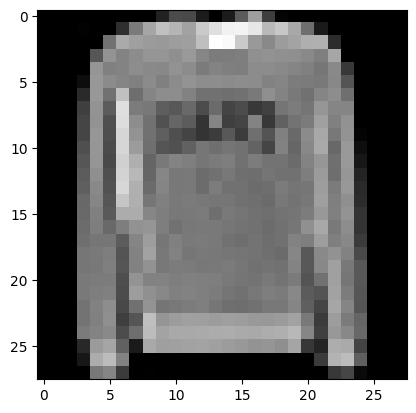

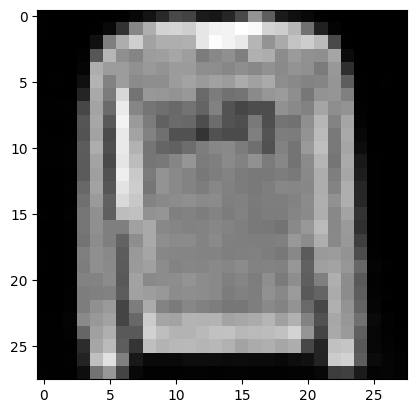

In [80]:
plt.imshow(i[0,0].cpu().detach().numpy(), cmap="gray")
plt.show()

plt.imshow(output[0,0].cpu().detach().numpy(), cmap="gray")
plt.show()

In [42]:
# Function to add Gaussian noise to an image tensor
def add_gaussian_noise(image, mean=0., std=1.):
    eps = torch.empty_like(image).normal_(mean=0,std=1)
    noise = eps * std + mean
    # beta*eps + sqrt(1-beta)*image+std # (1-beta).sqrt()*image + beta*eps
    # Clip the values to be between 0 and 1
    # noisy_image = normalize_image(noisy_image)
    return noise, eps

In [43]:
def create_linear_schedule(steps, start, end):
    step_size = (end - start) / (steps - 1)  
    linear_schedule = []
    for i in range(steps):
        linear_schedule.append(start + i * step_size)
    return linear_schedule



In [44]:
def berechne_alpha_quer_x_forward_steps(anzahl_steps):
    scheduler = create_linear_schedule(anzahl_steps, 0.0001, 0.02)
    alphas = 1 - np.array(scheduler)
    alphas_quer = []
    for i in range(len(alphas)):
        alphas_quer.append(np.prod(alphas[:i + 1]))
    return alphas_quer

In [45]:
def x_forward_steps(curr_image, alpha_quer):
    alpha_quer = torch.tensor(alpha_quer, dtype=torch.float32).to(device)  # 'device' is your CUDA device
    std = torch.sqrt(1 - alpha_quer)
    mean = torch.sqrt(alpha_quer) * curr_image
    new_image, eps = add_gaussian_noise(curr_image,mean=mean,std=std)
    return new_image, eps

In [46]:
def mache_noise_direkt_random(batch_images, total_steps=1000, device=device):
    # Verschieben Sie den Batch auf die GPU
    batch_images = batch_images.to(device)
    
    # Annahme: batch_images hat die Form [batch_size, channels, height, width]
    batch_size = batch_images.size(0)
    
    alpha_quer_list = berechne_alpha_quer_x_forward_steps(total_steps)
    alpha_quer = torch.tensor(alpha_quer_list, device=device)

    noisy_batch = []
    epsilons = []
    anzahl_steps_array = np.empty(batch_size)
    # for loop vernichten
    for i in range(batch_size):
        anzahl_steps = np.random.randint(total_steps)
        anzahl_steps_array[i] = anzahl_steps
        
        image = batch_images[i]
        noisy_image, eps = x_forward_steps(image.unsqueeze(0).to(device), alpha_quer[anzahl_steps-1])  # Verschieben auf die GPU
        
        noisy_batch.append(noisy_image)
        epsilons.append(eps)
    
    noisy_batch_tensor = torch.cat(noisy_batch, dim=0).to(device)  # Verschieben auf die GPU
    epsilons_tensor = torch.cat(epsilons, dim=0).to(device)  # Verschieben auf die GPU
    
    return noisy_batch_tensor, epsilons_tensor, anzahl_steps_array


In [47]:
import torch.nn as nn

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
            
        )

    def forward(self, x):
        return self.double_conv(x)


In [48]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            #nn.MaxPool2d(2),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.LeakyReLU(inplace=True),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [49]:
# Comments inspired from https://distill.pub/2016/deconv-checkerboard/

#Stride 1 deconvolutions — which we often see as the last layer in successful models 
#(eg. [2])  — are quite effective at dampening artifacts. 
#In particular, deconvolution has uneven overlap when the kernel size 
#(the output window size) is not divisible by the stride (the spacing between points on the top).

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True))
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        #Diese Zeilen berechnen die Größenunterschiede
        #in den Höhen- und Breitenrichtungen zwischen x2 und dem upgesampleten x1.
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        #Diese Zeile fügt x1 an den Rändern Polster hinzu, 
        #sodass es die gleiche räumliche Größe wie x2 hat. Das 
        #Padding sorgt dafür, dass die beiden Feature-Maps aneinander angehängt werden können.

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [50]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [51]:
def concat_pos_param(x, enc):
    if x.shape[0] == 1:
        pos_enc_reshape = enc[None,:,None,None].expand((-1,-1,x.shape[-2],x.shape[-1]))
        feature_map_with_encoding = torch.cat([x.to(device), pos_enc_reshape.to(device)], dim=1)
    else: 
        pos_enc_reshape = enc[:,:,None,None].expand((-1,-1,x.shape[-2],x.shape[-1]))
        feature_map_with_encoding = torch.cat([x.to(device), pos_enc_reshape.to(device)], dim=1)
    return feature_map_with_encoding

In [52]:
def get_sinusoid_encoding_table(n_position, d_hid):
    ''' Sinusoid position encoding table '''

    def get_position_angle_vec(position):
        return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

    sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return torch.FloatTensor(sinusoid_table)#.unsqueeze(0)

In [30]:
class UNet(nn.Module):
    def __init__(self, n_channels, t_max=1000, d_hid=32, channels=[64,128,256,512,1024,2048]):
        super(UNet, self).__init__()
        assert len(channels) == 6
        self.n_channels = n_channels
        
        factor = 2
        self.pos_enc = nn.parameter.Parameter(get_sinusoid_encoding_table(t_max, d_hid), requires_grad=False)
        #self.pos_enc.requires_grad = False 
        self.inc = (DoubleConv(n_channels + d_hid, channels[0]))
        self.down1 = (Down(channels[0] + d_hid, channels[1]))
        self.down2 = (Down(channels[1] + d_hid, channels[2]))
        self.down3 = (Down(channels[2] + d_hid, channels[3]))
        self.up3 = (Up(channels[-3], channels[-4]))
        self.up4 = (Up(channels[-4], channels[-5]))
        self.up5 = (Up(channels[-5], channels[-6]))
        self.outc = (OutConv(channels[-6], n_channels))
        apply_weight_init_fn(self, leaky_relu_init, negative_slope=0.0)

    def forward(self, x, t):
        enc = self.pos_enc[t]
        #enc_reshape = enc[:,:,None,None].expand((-1,-1,x.shape[-2],x.shape[-1]))
        #enc = self.pos_enc[t]
        #print(torch.cat([x, enc_reshape],dim=1).shape)
        x1 = self.inc(concat_pos_param(x,enc))
        x2 = self.down1(concat_pos_param(x1, enc))
        x3 = self.down2(concat_pos_param(x2, enc))
        x4 = self.down3(concat_pos_param(x3, enc))
        #x7 = self.bottleneck(x7)
        #x4 = self.down3(x3)
        #x5 = self.down4(x4)
        #x = self.up1(x5, x4)
        
        x = self.up3(x4, x3)
        x = self.up4(x, x2)
        x = self.up5(x, x1)
        logits = self.outc(x)
        return logits
    

In [31]:
unet = UNet(64).to(device)

learning_rate = 0.002
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=learning_rate, weight_decay = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, verbose=True)

def evaluate(net, dataloader, device):
    net.eval()
    num_val_batches = len(dataloader)
    

    
    progress_bar = tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False)
    for batch in progress_bar:
        image, mask_true = batch[0], batch[1]

            # move images and labels to correct device and type
        image = image.to(dtype=torch.float32, memory_format=torch.channels_last).cpu()
        image = autoencoder.encoder(image)
        noisy_image, eps, anzahl_schritte = mache_noise_direkt_random(image)
        mask_true = mask_true.to(dtype=torch.long)
        
        mask_pred = net(noisy_image, anzahl_schritte).to(device)
        
        loss = criterion(mask_pred, eps)
        
        


    net.train()
    return 

In [32]:
def train_model_unet(
        model,
        device,
        epochs: int = 40,
        learning_rate: float = 1e-2,
        val_percent: float = 0.1,
        img_scale: float = 0.5,
        weight_decay: float = 1e-8,
        gradient_clipping: float = 1.0,
):
    
    min_loss = 1e25
    progress_bar = tqdm(range(epochs), total=epochs, position=0, leave=True)
    for epoch in progress_bar:
        mean_epoch_loss = []
        model.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            image, mask_true = [t.to(device) for t in data]
            progress_bar.set_postfix({f'T of {[len(trainloader)]}' : i+1, 'Best loss': min_loss}, refresh=True)
            optimizer.zero_grad()
                # move images and labels to correct device and type
            image = image.to(dtype=torch.float32, memory_format=torch.channels_last)
            image = autoencoder.encoder(image)
            noisy_image, eps, anzahl_schritte = mache_noise_direkt_random(image)
            mask_true = mask_true.to(dtype=torch.long)

            mask_pred = model(noisy_image, anzahl_schritte).to(device)

            loss = criterion(mask_pred, eps)
            mean_epoch_loss.append(loss.item())

            loss.backward()
            optimizer.step()
            
            
            running_loss += loss.item()
        
        loss_mean = np.mean(mean_epoch_loss)
        # scheduler on loss_mean with patience 10 with more aggressive learning rate
        scheduler.step(loss_mean)
        if loss_mean < min_loss:
            min_loss = loss_mean
            #torch.save(model, 'fmnist_model_latent.pt')
        if epoch%5==0:
            print('---')
            print(f"Epoch: {epoch} | Train Loss: {loss_mean} | Best Loss: {min_loss}")

                
    #evaluate(model, valloader, device) 


In [33]:
train_model_unet(unet,device)

  0%|                                                                                                                                                         | 0/40 [00:00<?, ?it/s, T of [30]=1, Best loss=1e+25]/tmp/ipykernel_265103/1524519049.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_quer = torch.tensor(alpha_quer, dtype=torch.float32).to(device)  # 'device' is your CUDA device
  2%|███▌                                                                                                                                            | 1/40 [00:08<05:30,  8.48s/it, T of [30]=30, Best loss=1e+25]

---
Epoch: 0 | Train Loss: 1.1088049372037252 | Best Loss: 1.1088049372037252


 15%|█████████████████████▌                                                                                                                          | 6/40 [00:49<04:37,  8.17s/it, T of [30]=30, Best loss=0.689]

---
Epoch: 5 | Train Loss: 0.6335643390814464 | Best Loss: 0.6335643390814464


 28%|███████████████████████████████████████▎                                                                                                       | 11/40 [01:30<03:56,  8.17s/it, T of [30]=30, Best loss=0.487]

---
Epoch: 10 | Train Loss: 0.47229868868986763 | Best Loss: 0.47229868868986763


 40%|█████████████████████████████████████████████████████████▏                                                                                     | 16/40 [02:12<03:21,  8.39s/it, T of [30]=30, Best loss=0.431]

---
Epoch: 15 | Train Loss: 0.4263543983300527 | Best Loss: 0.4263543983300527


 52%|███████████████████████████████████████████████████████████████████████████                                                                    | 21/40 [02:54<02:38,  8.34s/it, T of [30]=30, Best loss=0.414]

---
Epoch: 20 | Train Loss: 0.41097674568494164 | Best Loss: 0.41097674568494164


 65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 26/40 [03:35<01:55,  8.23s/it, T of [30]=30, Best loss=0.408]

---
Epoch: 25 | Train Loss: 0.4031215399503708 | Best Loss: 0.4031215399503708


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 31/40 [04:16<01:13,  8.15s/it, T of [30]=30, Best loss=0.399]

---
Epoch: 30 | Train Loss: 0.39674555957317353 | Best Loss: 0.39674555957317353


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 36/40 [04:55<00:32,  8.00s/it, T of [30]=30, Best loss=0.394]

---
Epoch: 35 | Train Loss: 0.3969858338435491 | Best Loss: 0.3939336270093918


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [05:28<00:00,  8.22s/it, T of [30]=30, Best loss=0.391]


In [34]:
def mache_noise_direkt(image, anzahl_steps, total_steps=1000):
    # Convert the image to a PyTorch tensor
    # transform = transforms.ToTensor()
    # image_tensor = transform(image)
    
    noisy_image_tensor = image
    
    alpha_quer = berechne_alpha_quer_x_forward_steps(total_steps)
    
    noisy_image_tensor, eps = x_forward_steps(noisy_image_tensor, alpha_quer[anzahl_steps-1])
    noisy_image = ((noisy_image_tensor/2)+0.5).cpu().squeeze()
    
    return noisy_image_tensor, eps


In [37]:
unet = torch.load('fmnist_model_latent.pt')
unet.eval()
unet.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNor

torch.Size([2048, 1, 28, 28])


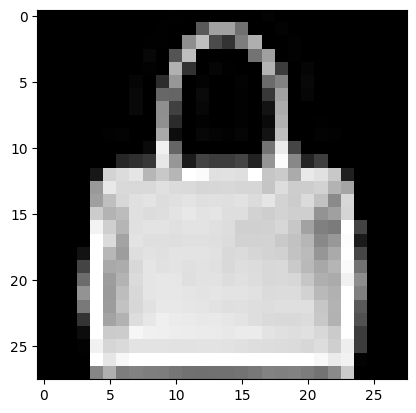

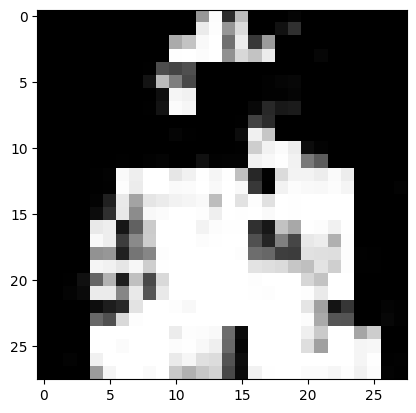

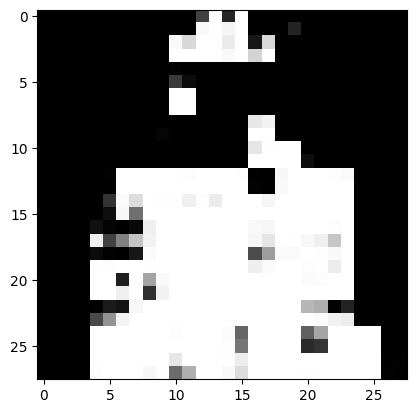

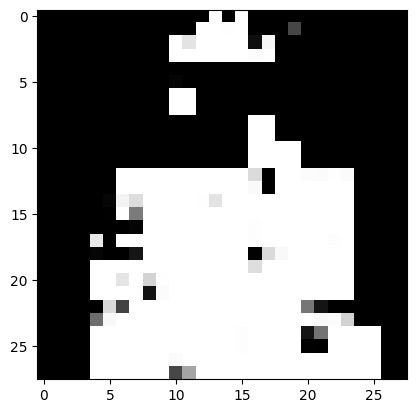

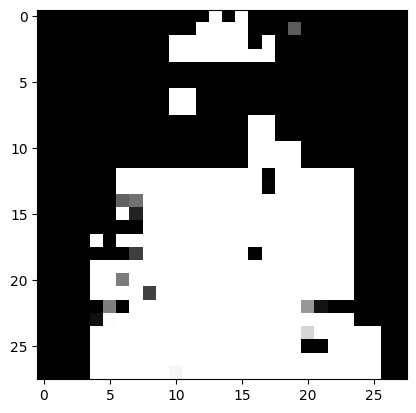

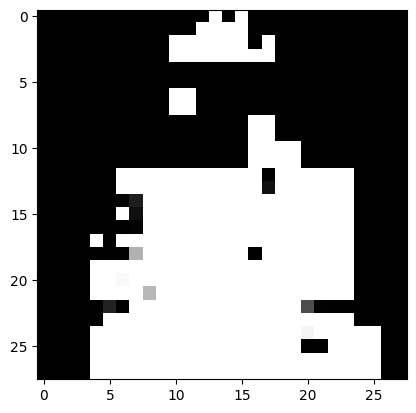

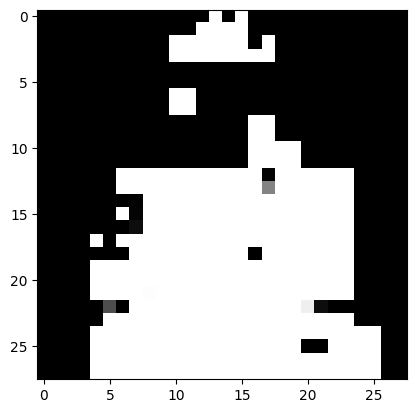

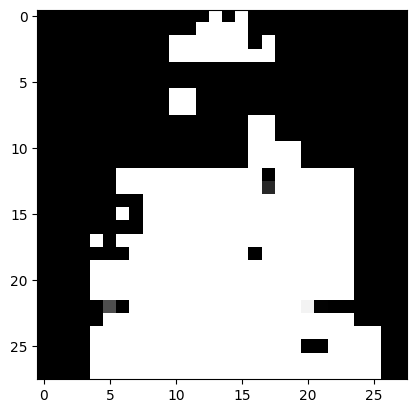

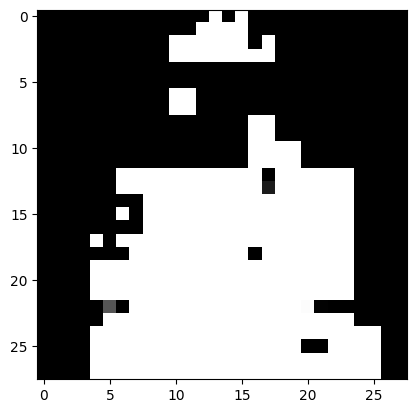

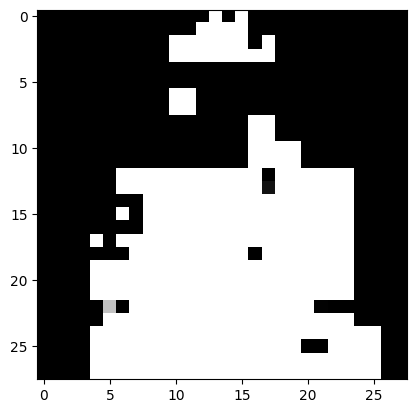

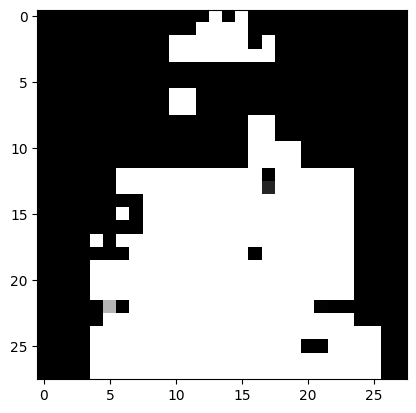

In [62]:
from IPython.display import display, clear_output

betas = create_linear_schedule(1000, 0.0001, 0.02)
alphas = 1 - np.array(betas)
alphas_quer = []
for k in range(len(alphas)):
    alphas_quer.append(np.prod(alphas[:k + 1]))

#latent_noise, eps = mache_noise_direkt(i[0:1].to(device), 1000)
print(i.shape)
plt.imshow(i[0,0].cpu().detach().numpy(), cmap="gray")
plt.show()
latent_noise = autoencoder.encoder(i[0:1].to(device))
#img_noise = torch.randn_like(img_noise)
#latent_noise = torch.randn((1,64,7,7)).to(device)
fig, ax = plt.subplots()

for j in reversed(range(999)):    
    img_pred = unet(latent_noise, j)
    if j > 1:
        z = torch.randn_like(latent_noise)
    else:
        z = torch.zeros_like(latent_noise)
    #ausführliche Definition von Sigma:   
    #img_noise = (1/np.sqrt(alphas[j+1])) * (img_noise - ((1- alphas[j+1])/(np.sqrt(1-alphas_quer[j+1]))) * img_pred) + np.sqrt((1-alphas_quer[j])/(1-alphas_quer[j+1]) *betas[j+1])*z
    #Sigma^2 = beta:
    # Alter Ansatz: DDPM
    latent_noise = (1/np.sqrt(alphas[j+1])) * (latent_noise - ((1- alphas[j+1])/(np.sqrt(1-alphas_quer[j+1]))) * img_pred) + np.sqrt(betas[j+1])*z
    
    
    if j % 100 == 0:
        img_noise = autoencoder.decoder(latent_noise)
        #clear_output(wait=True)  # Löscht die vorherige Ausgabe
        plt.imshow(img_noise[0,0].cpu().detach().numpy(), cmap="gray")
        plt.show()
